## Example 1 - creating structured and unstructured meshes

`Quagmire` can model surface processess on a structured rectangular grid or unstructured triangulated points. These use-cases are bundled into two objects:

- `PixMesh`: meshing on a rectangular grid
- `TriMesh`: meshing on unstructured triangular points

All meshes are generated and handed to Quagmire using a `DM` object where the selection of `PixMesh` or `TriMesh` is identified automatically by `FlatMesh`. The following data structures are built:

- Delaunay triangulation
- node neighbour array
- pointwise area and weights
- boundary information
- Rbf smoothing kernel

In this notebook we setup different `DM` objects using meshes found in the `quagmire.tools.meshtools` path and hand them to `FlatMesh`.


#### Contents

- [Structured grids](#Structured-grids)
- [Unstructued meshes](#Unstructured-meshes)
- [Elliptical mesh](#Elliptical-mesh)
- [Mesh improvement](#Mesh-improvement)
- [Mesh refinement](#Mesh-refinement)
- [Save mesh to file](#Save-mesh-to-file)

In [1]:
from quagmire.tools import meshtools
from quagmire import FlatMesh

In [2]:
import numpy as np

## Structured grids

In [3]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0

resX = 75
resY = 75

DM = meshtools.create_DMDA(minX, maxX, minY, maxY, resX, resY)

print(type(DM))

<type 'petsc4py.PETSc.DMDA'>


This is a native PETSc data management object for structured grids (`DMDA`). This object has a number of 
useful methods and attached data which can be listed with

```python
help(DM)
```

We hand this to `FlatMesh` to generate the necessary data structures for gradient operations, smoothing, neighbour allocation, etc.

In [4]:
mesh = FlatMesh(DM)

 - Construct neighbour array 0.008279s
 - cKDTree 0.002259s
 - Find boundaries 0.000295s
 - Build smoothing matrix 0.001745s
 - Construct neighbour cloud array 0.021084s
 - Construct rbf weights 0.00646s


We attach data to a mesh solely by association

```python
   mesh_data = np.empty(mesh.npoints)
   mesh_data = np.sin(mesh.coords[:,0] * np.pi)
```

In [5]:
mesh_data = np.empty(mesh.npoints)
mesh_data = np.sin(mesh.coords[:,0] * np.pi)
mesh_data2 = np.cos(mesh.coords[:,1] * np.pi) * mesh_data

In [7]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[500,500], near=-10.0)

lvmesh = lv.quads(dims=(mesh.nx, mesh.ny), wireframe=True)
lvmesh.vertices(mesh.coords)
lvmesh.values(mesh_data, "sinx")
lvmesh.colourmap("#FF0000, #555555 #0000FF", range=[-1.0,1.0])

# The mesh can be given a height mapping like this

vertices = np.zeros((mesh.coords.shape[0],3))
vertices[:,0:2] = mesh.coords
vertices[:,2] = mesh_data2 * 0.5

lvmesh2 = lv.quads(dims=(mesh.nx, mesh.ny), wireframe=False)
lvmesh2.vertices(vertices)
lvmesh2.values(mesh_data2,"sinxcosy")
lvmesh2.colourmap("#FF0000, #FFFFFF:0.5 #0000FF", range=[-1.0,1.0])


lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

## Unstructured meshes

This is handled by PETSc's `DMPlex` object, which requires the connectivity of a set of points. The connectivity between points can be triangulated using the built-in mesh creation tools:

```python
x, y, simplices = square_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
x, y, simplices = elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
```

and handed to `DMPlex` using:

```python
DM = meshtools.create_DMPlex(x, y, simplices, boundary_vertices=None)
```

---

Alternatively, an arbitrary set of points (without duplicates) can be triangulated and processed as a `DMPlex` object using:

```python
meshtools.create_DMPlex_from_points(x, y, bmask=None)
```

If no boundary information is provided, the boundary is assumed to be the convex hull of points.


#### Parallel notes

The triangulation from the root processor is distributed to other processors using the `DM` object, including boundary points and boundary edges. The mesh can be refined efficiently in parallel using the `refine_dm` method. The order of this operation is important:

1. Triangulate points
2. Mark boundary edges
3. Distribute `DMPlex` to other processors
4. Refine the mesh

## Elliptical mesh

In [23]:
spacingX = 0.1
spacingY = 0.1

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
DM = meshtools.create_DMPlex(x, y, simplices)

mesh = FlatMesh(DM)

0 - Delaunay triangulation 0.005168s
0 - Calculate node weights and area 0.000658s
0 - Find boundaries 0.000127s
0 - cKDTree 0.000772s
0 - Construct neighbour cloud array 0.014679s
0 - Construct rbf weights 0.004392s


In [11]:
mesh_equant = mesh.neighbour_cloud_distances.mean(axis=1) / ( np.sqrt(mesh.area))

In [12]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

# lavavu also works in 3D - so need to stitch in a Z component  (zero or a height)

vertices = np.zeros((mesh.tri.points.shape[0],3))
vertices[:,0:2] = mesh.tri.points
# vertices[:,2] = heights

bnodes = lv.points("Boundary Points", pointsize=10.0, pointtype="shiny", colour="red", opacity=0.75)
bnodes.vertices(vertices[~mesh.bmask])

simp = lv.triangles("Triangle Edges", wireframe=True, colour="#442222", opacity=0.75)
simp.vertices(vertices)
simp.indices(mesh.tri.simplices)

tris = lv.triangles("Triangle Areas",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(vertices-(0.0,0.0,0.01))
tris.indices(mesh.tri.simplices)
tris.values(mesh_equant, label="pointwise_area")

tris.colourmap("#000000, #FFFFFF")
cb = tris.colourbar()

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

lv.show()

<IPython.core.display.Javascript object>

## Mesh improvement

Applies Lloyd's algorithm of iterated voronoi construction to improve the mesh point locations. This distributes the points to a more uniform spacing with more equant triangles. It can be very slow for anything but a small mesh. [Refining](#Mesh-refinement) the mesh a few times will produce a large, well-spaced mesh.

In [13]:
bmask = mesh.bmask.copy()

x1, y1 = meshtools.lloyd_mesh_improvement(x, y, bmask, iterations=3)
DM = meshtools.create_DMPlex_from_points(x1, y1, bmask)

mesh1 = FlatMesh(DM)

0 - Delaunay triangulation 0.00352s
0 - Calculate node weights and area 0.000423s
0 - Find boundaries 8.40000000002e-05s
0 - cKDTree 0.000668s
0 - Construct neighbour cloud array 0.010923s
0 - Construct rbf weights 0.0029s


In [14]:
mesh1_equant = mesh1.neighbour_cloud_distances.mean(axis=1) / ( np.sqrt(mesh1.area))

In [15]:
import lavavu

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

# lavavu assumes 3D - so need to stitch in a Z component  (zero or a height)

vertices = np.zeros((mesh1.tri.points.shape[0],3))
vertices[:,0:2] = mesh1.tri.points

bnodes = lv.points("Boundary Points", pointsize=10.0, pointtype="shiny", colour="red", opacity=0.75)
bnodes.vertices(vertices[~mesh1.bmask])

simp = lv.triangles("Triangle Edges", wireframe=True, colour="#442222", opacity=0.75)
simp.vertices(vertices)
simp.indices(mesh1.tri.simplices)

tris = lv.triangles("Triangle Areas",  wireframe=False, colour="#77ff88", opacity=1.0)
tris.vertices(vertices-(0.0,0.0,0.01))
tris.indices(mesh1.tri.simplices)
tris.values(mesh1_equant, label="pointwise_area")

tris.colourmap("#000000, #FFFFFF", range=[1.0,0.9*mesh1_equant.mean()])

cb = tris.colourbar()

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

lv.show()

<IPython.core.display.Javascript object>

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


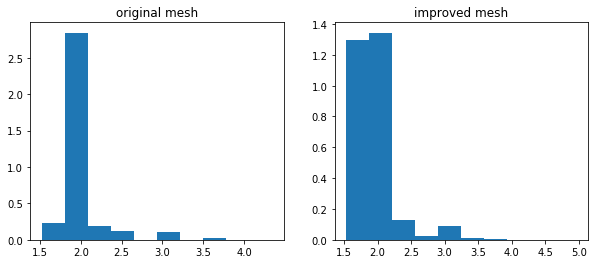

In [16]:
# Comparison of point-wise area for original and improved mesh


import matplotlib.pyplot as plt
%matplotlib inline


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

ax1.hist(mesh_equant, normed=True)
ax2.hist(mesh1_equant, normed=True)

ax1.set_title('original mesh')
ax2.set_title('improved mesh')

plt.show()

## Mesh refinement

Triangulating a large set of points on a single processor then distributing the mesh across multiple processors can be very slow. A more time effective workflow is to create an initial `DM` with a small number of points, then refine the mesh in parallel. This is achieved by adding the midpoint of each line segment to the mesh and can be iteratively refined until the desired level of detail is reached.

```python
refine_DM(dm, refinement_steps=1)
```

In [17]:
spacingX = 0.5
spacingY = 0.5

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, spacingX, spacingY)
DM = meshtools.create_DMPlex(x, y, simplices)

DM_r1 = meshtools.refine_DM(DM, refinement_steps=1)
DM_r2 = meshtools.refine_DM(DM, refinement_steps=2)


# verbose=False turns off the timings

mesh0 = FlatMesh(DM, verbose=False)
mesh1 = FlatMesh(DM_r1, verbose=False)
mesh2 = FlatMesh(DM_r2, verbose=False)

In [18]:
mesh0.coords.shape

(91, 2)

In [19]:
def plot_points(lv, points, label, **kwargs):
    vertices = np.zeros((points.shape[0],3))
    vertices[:,0:2] = points
    
    lv_pts = lv.points(label, **kwargs)
    lv_pts.vertices(vertices)
    return lv_pts

def plot_triangles(lv, points, triangles, label, **kwargs):
    vertices = np.zeros((points.shape[0],3))
    vertices[:,0:2] = points

    lv_tri = lv.triangles(label, **kwargs)
    lv_tri.vertices(vertices)
    lv_tri.indices(triangles)
    return lv_tri


lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

bnodes0 = plot_points(lv, mesh0.coords[~mesh0.bmask], "boundary_points_r0", colour="red", pointsize=10)
bnodes1 = plot_points(lv, mesh1.coords[~mesh1.bmask], "boundary_points_r1", colour="blue", pointsize=10)
bnodes2 = plot_points(lv, mesh2.coords[~mesh2.bmask], "boundary_points_r2", colour="#336611", pointsize=10)

tri0 = plot_triangles(lv, mesh0.coords, mesh0.tri.simplices, "mesh_r0", wireframe=True, linewidth=1.5, colour="red")
tri1 = plot_triangles(lv, mesh1.coords, mesh1.tri.simplices, "mesh_r1", wireframe=True, linewidth=1.0, colour="blue")
tri2 = plot_triangles(lv, mesh2.coords, mesh2.tri.simplices, "mesh_r2", wireframe=True, linewidth=1.0, colour="#336611")

lv.control.Panel()
lv.control.ObjectList()
lv.control.show()

lv.show()

<IPython.core.display.Javascript object>

The DM contains two labels -- "coarse" and "boundary" -- which contain the vertices of boundary nodes and the unrefined mesh, respectively. They can be retrieved using:

```python
mesh.get_label("boundary")
mesh.get_label("coarse")
```

or a new label can be set using:

```python
mesh.set_label("my_label", indices)
```

In [20]:
coarse_pts0 = mesh0.get_label("coarse")
coarse_pts1 = mesh1.get_label("coarse")
coarse_pts2 = mesh2.get_label("coarse")

print("{} boundary points".format( len(mesh0.get_label("boundary")) ))
print("{} boundary points".format( len(mesh1.get_label("boundary")) ))
print("{} boundary points".format( len(mesh2.get_label("boundary")) ))


# the coarse point vertices should be identical
# refinement adds new points to the end of the x,y arrays

set(coarse_pts0) == set(coarse_pts1) == set(coarse_pts2)

18 boundary points
36 boundary points
72 boundary points


True

## Save mesh to file

A mesh can be saved and imported later. The `FlatMesh` object has the `save_mesh_to_hdf5` method for this, as does `meshtools`.

**Note:** Requires PETSc 3.8 or higher

In [22]:
filename = "refined_mesh.h5"

# save from FlatMesh object:
# mesh2.save_mesh_to_hdf5(filename)

# save from meshtools:
meshtools.save_DM_to_hdf5(DM_r2, filename)

# load DM from file
DM_r2 = meshtools.create_DMPlex_from_hdf5(filename)

mesh2 = FlatMesh(DM_r2)

AttributeError: 'petsc4py.PETSc.DMPlex' object has no attribute 'createFromFile'

The next example is [Ex2-Topography-Meshes](./Ex2-Topography-Meshes.ipynb)